# Thin film lithium niobate adiabatic waveguide coupler

> **Note: the cost of running the entire notebook is over 20 FlexCredits.**

Thin-film lithium niobate (LN) offers several advantages over silicon in integrated photonics. LN's inherent electro-optic and nonlinear properties exceed those of silicon, allowing for efficient electro-optic modulation and wavelength conversion, which are vital for optical signal processing. Furthermore, LN demonstrates lower optical loss in the telecom wavelengths, and it supports operation in a broader wavelength range compared to silicon, extending into the mid-infrared region. Thus, thin-film LN's characteristics present opportunities for the realization of high-performance, multi-functional integrated photonic devices.

In this notebook, we introduce an adiabatic LN waveguide coupler based on a special arrayed scheme with three waveguides. The coupling mechanism is analogous to the stimulated Raman adiabatic passage (STIRAP) in quantum physics. Adiabatic light transfer can be achieved from one outer waveguide to the other outer waveguide with near unity coupling efficiency and minimum excitation of the middle waveguide. More importantly, the designed coupler has a high fabrication tolerance, small mode and polarization sensitivity, and large working bandwidth. The design is based on `Yi-Xin Lin, Mohammadreza Younesi, Hung-Pin Chung, Hua-Kung Chiu, Reinhard Geiss, Quan-Hsiang Tseng, Frank Setzpfandt, Thomas Pertsch, and Yen-Hung Chen, "Ultra-compact, broadband adiabatic passage optical couplers in thin-film lithium niobate on insulator waveguides," Opt. Express 29, 27362-27372 (2021)` [DOI: 10.1364/OE.435633](https://doi.org/10.1364/OE.435633).

Adiabatic devices usually have a better fabrication tolerance and working bandwidth. However, the device size is inevitably larger, making rigorous simulation a daunting task. Photonic designers often resort to approximation methods such as 2D FDTD, beam propagation method, eigenmode expansion, and so on. The accuracy of these simulations is often questionable. `Tidy3D` allows photonic designers to perform accurate 3D FDTD for large devices in a short amount of time, eliminating all the compromises and giving you confidence in your design. 

<img src="img/LN_adiabatic_coupler.png" width="400" alt="Schematic of the adiabatic coupler">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [2]:
import tidy3d as td
import tidy3d.web as web

import numpy as np
import matplotlib.pyplot as plt
import gdstk

## Simulation Setup 

In [3]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency

ldas = np.linspace(1.45, 1.65, 101)  # wavelength range of interest
freqs = td.C_0 / ldas  # frequency range of interest

fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency

The coupler is designed on an X-cut thin film LN. The waveguides are oriented perpendicular to the optical axis. We plan to define our waveguides to be oriented in the $x$ direction in our simulation. Therefore, LN is defined as an [AnisotropicMedium](../_autosummary/tidy3d.AnisotropicMedium.html) with the extraordinary refractive index in the $y$ direction.

In the wavelength range of interest, both LN and SiO$_2$ have a constant refractive index so we model them as non-dispersive.

In [4]:
n_e = 2.138  # extraordinary refractive index of LN
n_o = 2.211  # ordinary refractive index of LN

# define LN medium
LN_e = td.Medium(permittivity=n_e**2)
LN_o = td.Medium(permittivity=n_o**2)
LN = td.AnisotropicMedium(xx=LN_o, yy=LN_e, zz=LN_o)

n_sio2 = 1.44  # refractive index of SiO2

# define SiO2 medium
SiO2 = td.Medium(permittivity=n_sio2**2)

Define geometric parameters. The length of the coupler is **2 mm**. The LN waveguide width and thickness are 1 $\mu m$ and 600 nm, respectively. 

In [5]:
L = 2000  # length of the coupler
d23 = 1  # spacing between the 2nd and the 3rd waveguide at the start of the coupler
d12 = 2  # spacing between the 1st and the 2nd waveguide at the start of the coupler
w = 1  # waveguide width
h = 0.6  # waveguide thickness

buffer = 10  # buffer spacing

Defining the geometries for the coupler is relatively easy as it only contains three straight waveguides. For convenience, we copy the `straight_waveguide` method from the list of [common integrated photonic components](https://www.flexcompute.com/tidy3d/examples/notebooks/PICComponents/) and use it to define the waveguides.

In [6]:
def straight_waveguide(x0, y0, z0, x1, y1, wg_width, wg_thickness, medium, sidewall_angle=0):
    """
    This function defines a straight strip waveguide and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide starting position (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("waveguide")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width, layer=1, datatype=0)  # define a path
    path.segment((x1, y1))

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    wg_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    wg = td.Structure(geometry=wg_geo[0], medium=medium)

    return wg

The three waveguides are simply defined by calling the `straight_waveguide` method with the respective start and end coordinates.

In [7]:
# define the first waveguide
wg1 = straight_waveguide(
    x0=-2 * buffer, y0=0, z0=0, x1=L + 2 * buffer, y1=0, wg_width=w, wg_thickness=h, medium=LN
)

# define the second waveguide
wg2 = straight_waveguide(x0=0, y0=d12, z0=0, x1=L, y1=d23, wg_width=w, wg_thickness=h, medium=LN)

# define the third waveguide
wg3 = straight_waveguide(
    x0=-2 * buffer,
    y0=d12 + d23,
    z0=0,
    x1=L + 2 * buffer,
    y1=d12 + d23,
    wg_width=w,
    wg_thickness=h,
    medium=LN,
)

Define source and monitors. Similar to other [PIC examples](https://www.flexcompute.com/tidy3d/examples/notebooks/YJunction/), we will use a [ModeSource](../_autosummary/tidy3d.ModeSource.html) to launch the waveguide mode at the first waveguide. More specifically, we will examine both the TE0 and TM0 modes and compute the coupling efficiencies. In the [ModeSpec](../_autosummary/tidy3d.ModeSpec.html), we only search for one mode as the TE0 and TM0 modes will be determined by the symmetry of the simulation as we will discuss later.

A [ModeMonitor](../_autosummary/tidy3d.ModeMonitor.html) is defined at the end of the third waveguide to capture the coupling efficiency and a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) is defined in the $z=0$ plane to help visualize the field propagation.

In [8]:
# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_e)
mode_source = td.ModeSource(
    center=(-buffer / 4, 0, 0),
    size=(0, 3 * w, 6 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)


# add a mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(L + buffer / 4, d12 + d23, 0),
    size=(0, 3 * w, 6 * h),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# add a field monitor to visualize field distribution at z=t/2
field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    fields=["Ex", "Ey", "Ez"],
    name="field",
)

13:24:42 PDT WARNING: Default value for the field monitor 'colocate' setting has
             changed to 'True' in Tidy3D 2.4.0. All field components will be    
             colocated to the grid boundaries. Set to 'False' to get the raw    
             fields on the Yee grid instead.                                    

We first define a [Simulation](../_autosummary/tidy3d.Simulation.html) for the TE0 mode by putting what we defined earlier together. Since the LN waveguides are surrounded by SiO$_2$, we can see that there is mirror symmetry with respect to the $z=0$ plane. The TE0 mode has a symmetry of `(0,0,1)` while the TM0 mode has a symmetry of `(0,0,-1)`. Therefore, the TM0 simulation is then simply defined by copying the TE0 simulation and updating the symmetry to `(0,0,-1)`.

Note that since the device has a large length, the simulation run time needs to be sufficiently long for the launched mode to propagate and decay. 

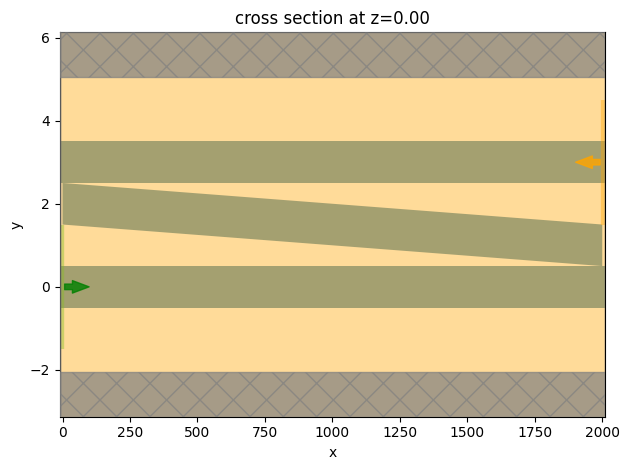

In [9]:
# define simulation domain size
Lx = L + 2 * buffer
Ly = d12 + d23 + w + 2 * lda0
Lz = 4 * h
sim_size = (Lx, Ly, Lz)

run_time = 4e-11  # simulation run time

# construct te0 simulation
sim_te = td.Simulation(
    center=(L / 2, (d12 + d23) / 2, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=12, wavelength=lda0),
    structures=[wg1, wg2, wg3],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=SiO2,
    symmetry=(0, 0, 1),
)

# define tm0 simulation by copying the te0 simulation and update the symmetry
sim_tm = sim_te.copy(update={"symmetry": (0, 0, -1)})

# plot the simulation to visualize the setup
ax = sim_te.plot(z=0)
ax.set_aspect("auto")
plt.show()

## Running Simulation Batch

We can run the two simulations sequentially. However, since both simulations are large, it would be much more efficient if we run them concurrently. To do so, we first define a simulation [Batch](../_autosummary/tidy3d.web.Batch.html) as demonstrated in the [tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/ParameterScan/). 

Before submitting the simulations to run on the server, we estimate the cost to ensure it is reasonable and affordable. This cost is the maximum cost assuming all time steps are used.

In [10]:
sims = {
    "TE": sim_te,
    "TM": sim_tm,
}
batch = web.Batch(simulations=sims, verbose=True)
estimate_cost = batch.estimate_cost()

             Created task 'TE' with task_id                                     
             'fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1' and task_type 'FDTD'.

             View task using web UI at ]8;id=758160;https://tidy3d.simulation.cloud/workbench?taskId=fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1\'https://tidy3d.simulation.cloud/workbenc]8;;\
             ]8;id=758160;https://tidy3d.simulation.cloud/workbench?taskId=fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1\h?]8;;\]8;id=996820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1\taskId]8;;\]8;id=758160;https://tidy3d.simulation.cloud/workbench?taskId=fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1\=]8;;\]8;id=996820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1\fdve]8;;\]8;id=758160;https://tidy3d.simulation.cloud/workbench?taskId=fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1\-464d389c-8a31-486c-906c-a016c8aa6db7v1']8;;\.

Output()

13:24:43 PDT Created task 'TM' with task_id                                     
             'fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1' and task_type 'FDTD'.

             View task using web UI at ]8;id=243948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1\'https://tidy3d.simulation.cloud/workbenc]8;;\
             ]8;id=243948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1\h?]8;;\]8;id=370759;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1\taskId]8;;\]8;id=243948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1\=]8;;\]8;id=370759;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1\fdve]8;;\]8;id=243948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1\-77e8c78b-5a0f-4c3b-8975-506e1f583500v1']8;;\.

Output()

13:24:55 PDT Maximum FlexCredit cost: 28.428 for the whole batch.

Once we confirm that the cost is correct, we run the batch of simulations in parallel.

In [11]:
batch_results = batch.run(path_dir="data")

13:24:56 PDT Started working on Batch.

13:25:07 PDT Maximum FlexCredit cost: 28.428 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

13:41:11 PDT Batch complete.

After the simulations are complete, we can get the real cost. Since the simulations automatically shut off after field decay reached the threshold, the real cost is lower than the estimated cost.

In [15]:
real_cost = batch.real_cost()

16:35:50 PDT Total billed flex credit cost: 24.448.

## Result Visualization

First, let's plot the field distribution for both the TE0 and TM0 simulations.

From the plots, we can see the efficient light transfer from one waveguide to the other in both polarizations with minimum excitation of the middle waveguide.

Output()

13:41:14 PDT loading simulation from                                            
             data/fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1.hdf5

Output()

13:41:45 PDT loading simulation from                                            
             data/fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1.hdf5

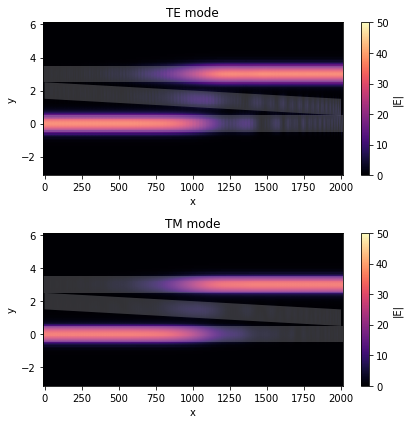

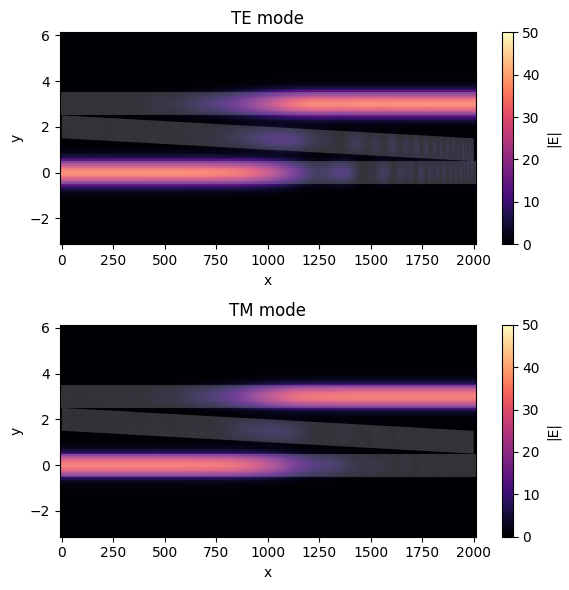

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), tight_layout=True)

batch_results["TE"].plot_field(
    field_monitor_name="field", field_name="E", val="abs", vmin=0, vmax=50, ax=ax1
)
ax1.set_aspect("auto")
ax1.set_title("TE mode")
batch_results["TM"].plot_field(
    field_monitor_name="field", field_name="E", val="abs", vmin=0, vmax=50, ax=ax2
)
ax2.set_aspect("auto")
ax2.set_title("TM mode")
plt.show()

Lastly, we quantitatively calculate and plot the coupling efficiencies. Within the 200 nm simulated bandwidth, we observe a >90% coupling efficiency for both polarizations.

13:42:16 PDT loading simulation from                                            
             data/fdve-464d389c-8a31-486c-906c-a016c8aa6db7v1.hdf5

             loading simulation from                                            
             data/fdve-77e8c78b-5a0f-4c3b-8975-506e1f583500v1.hdf5

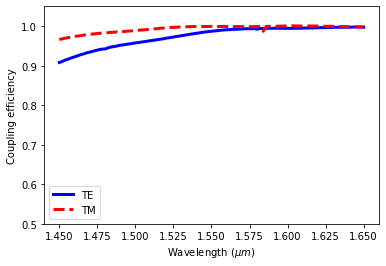

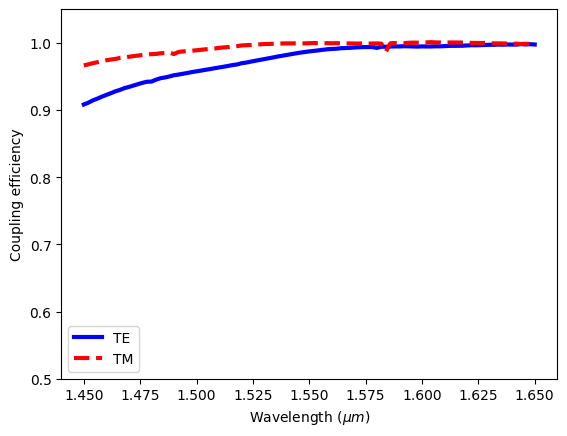

In [14]:
# extract the transmission data from the mode monitor
amp = batch_results["TE"]["mode"].amps.sel(mode_index=0, direction="+")
T_te = np.abs(amp) ** 2

amp = batch_results["TM"]["mode"].amps.sel(mode_index=0, direction="+")
T_tm = np.abs(amp) ** 2

plt.plot(ldas, T_te, c="blue", label="TE", linewidth=3)
plt.plot(ldas, T_tm, "--", c="red", label="TM", linewidth=3)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Coupling efficiency")
plt.ylim(0.5, 1.05)
plt.legend()
plt.show()

Further simulations can be used to test fabrication tolerance, nonzero sidewall angle, and so on, which we will not explicitly demonstrate here for the sake of brevity.